In [33]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets

import warnings
warnings.filterwarnings('ignore')


plt.ion()

In [10]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')
n=65
img_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1,2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


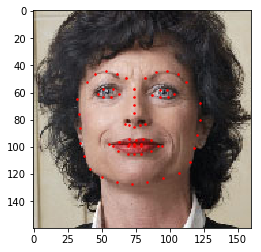

In [12]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

In [13]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx,0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        

0 (324, 215, 3) (68, 2)


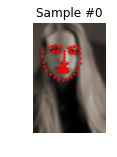

1 (500, 333, 3) (68, 2)


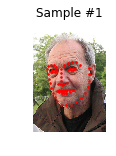

2 (250, 258, 3) (68, 2)


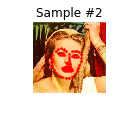

3 (434, 290, 3) (68, 2)


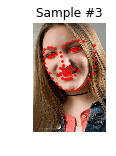

In [16]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv', root_dir='faces/')
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1,4, i+1)
    plt.tight_layout
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

In [20]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int,tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h,w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h,new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {'image': img, 'landmarks': landmarks}
    
class RandomCrop(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int,tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h,w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}
    
class ToTensor(object):
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


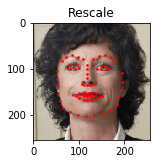

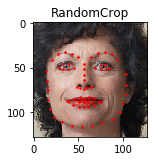

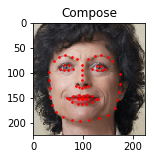

In [22]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1,3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

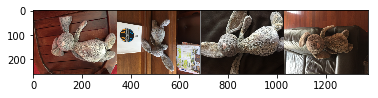

In [48]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    


data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
bbe_dataset = datasets.ImageFolder(root='./bbe', transform=data_transforms)
bbe_loader = torch.utils.data.DataLoader(bbe_dataset, batch_size=4, shuffle=True, num_workers=4)

fig = plt.figure()
images = iter(bbe_loader).next()
imshow(torchvision.utils.make_grid(images[0]))